# Energy Conversion Component Tests

## Imports

In [20]:
import pprint
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import copy
from energysys_components.energy_conversion import ECCParameter, ECCState,EnergyConversionComponent
from energysys_components.examples.component_definition import PEM, Cracker

## Definition of component

In [22]:
# Choose Component
#component = Cracker
component = PEM
pprint.pprint(component)

ECCParameter(name='Example PEM Fuel Cell',
             E_in_mc_type=ECarrier(name='Hydrogen',
                                   hu_kWh_kg=33.33,
                                   density_liquid__kg_m3=70.79,
                                   vol_energy_density_kWh_m3=2359.4307,
                                   color='#1982a8'),
             E_in_sd1_type=ECarrier(name='Hydrogen',
                                    hu_kWh_kg=33.33,
                                    density_liquid__kg_m3=70.79,
                                    vol_energy_density_kWh_m3=2359.4307,
                                    color='#1982a8'),
             E_in_sd2_type=ECarrier(name='Electricity',
                                    hu_kWh_kg=0,
                                    density_liquid__kg_m3=0,
                                    vol_energy_density_kWh_m3=0,
                                    color='#ccb80e'),
             E_out_type=ECarrier(name='Electricity',
                            

In [23]:
## Initialization of component
component_state = ECCState()
pprint.pprint(component_state)

ECCState(P_in=0,
         E_in=0,
         P_in_mc=0,
         E_in_mc=0,
         P_in_sd1=0,
         E_in_sd1=0,
         P_in_sd2=0,
         E_in_sd2=0,
         P_out=0,
         E_out=0,
         P_loss=0,
         E_loss=0,
         P_heat=0,
         E_heat=0,
         heatup=0,
         eta=0,
         eta_mc=0,
         opex_Eur=0,
         E_balance=0)


In [26]:
C1 = EnergyConversionComponent(par=component,
                      ts=1,
                     state=component_state)
pprint.pprint(C1)

## Run simple test cases

### Constant target output load from initial state (Stationary Step)

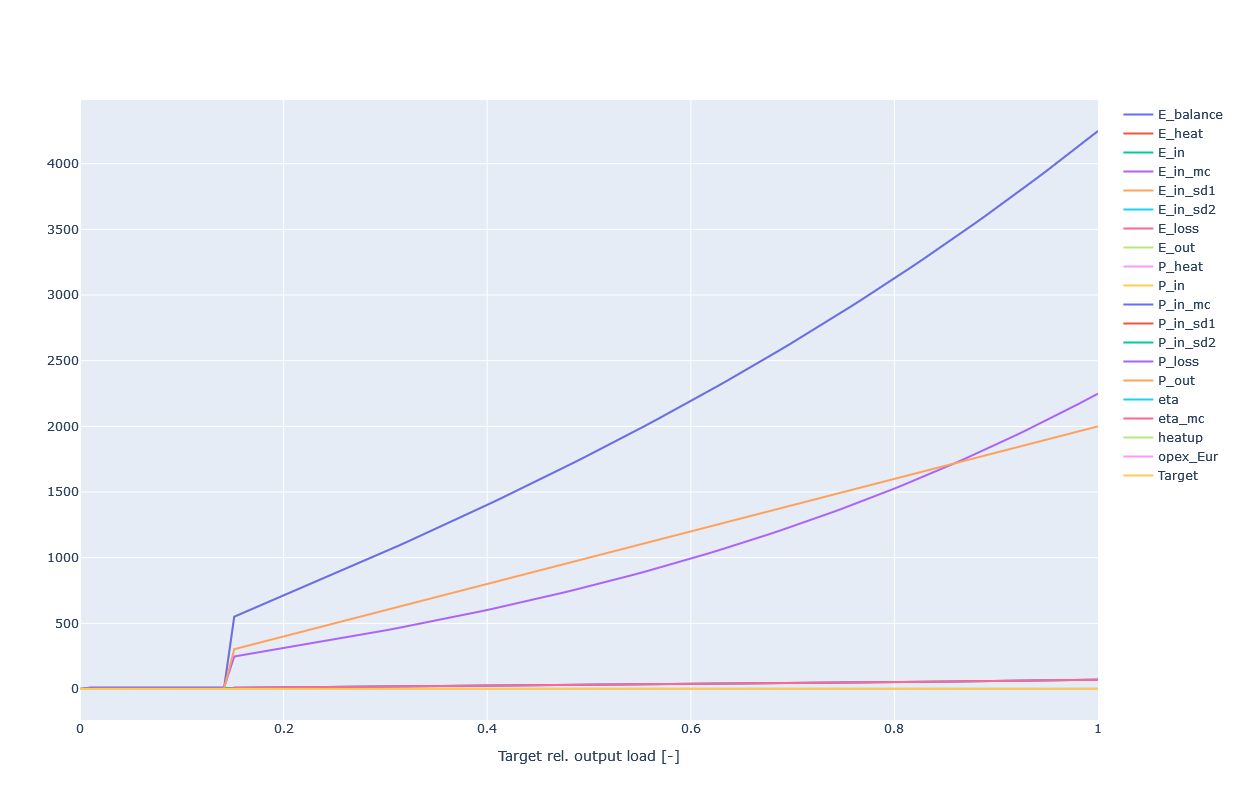

In [31]:
# Result DataFrame Initialization
state_parms = [a for a in dir(ECCState()) if not a.startswith('__')]
df1 = pd.DataFrame(columns=state_parms)
df1.loc[0] = vars(ECCState())

# Run different stationary cases for target output load
targets = np.linspace(0, 1., 100)

for ct, t in enumerate(targets):
    # Initialization of component
    C1_state = ECCState()
    C1 = EnergyConversionComponent(par=component,
                                   ts=1,
                                   state=copy.deepcopy(C1_state))
    C1.step_action_stationary(t)
    df1.loc[ct + 1] = vars(C1.state)
    df1.loc[ct + 1, "Target"] = t

# Create traces
fig = go.Figure()

# Create traces
for cl in df1.columns:
    fig.add_trace(go.Scatter(x=df1.Target[1:], y=df1[cl][1:],
                             mode='lines',
                             name=cl))
fig.update_layout(xaxis_title="Target rel. output load [-]",
                  # yaxis_title="Y Axis Title",
                  )
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()


### Constant target output load from initial state "off" to "target" and back to "off" (time steps)

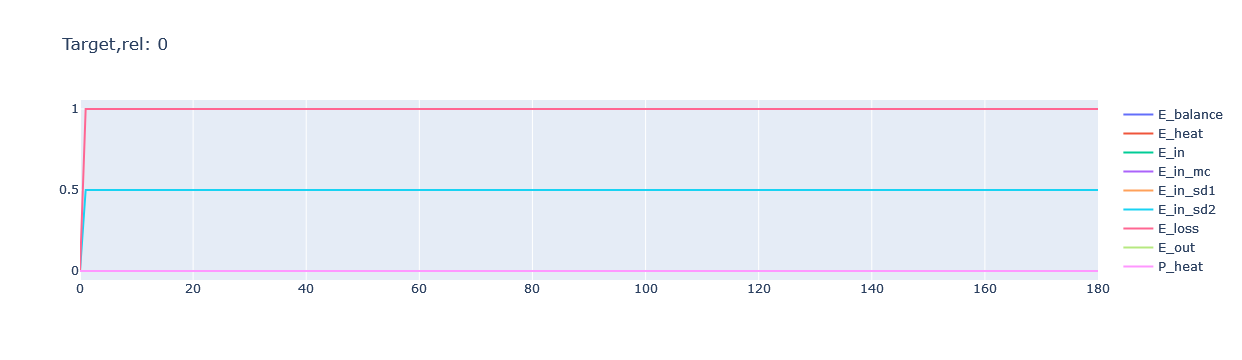

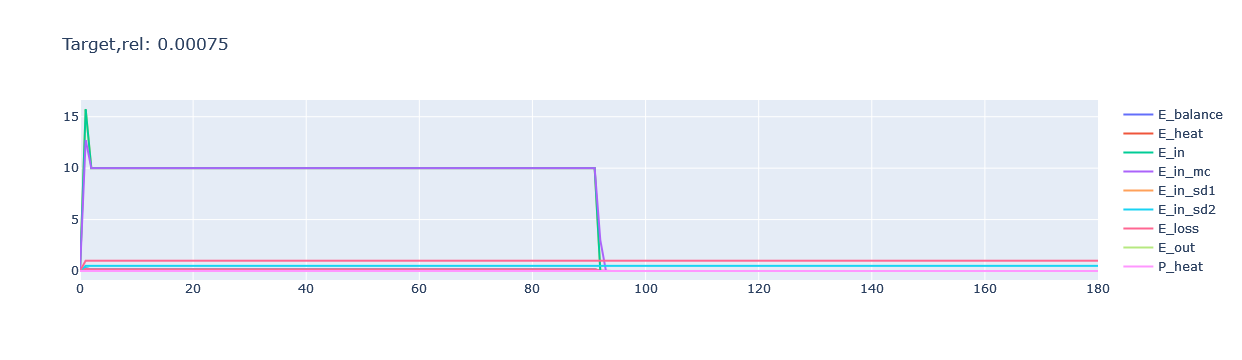

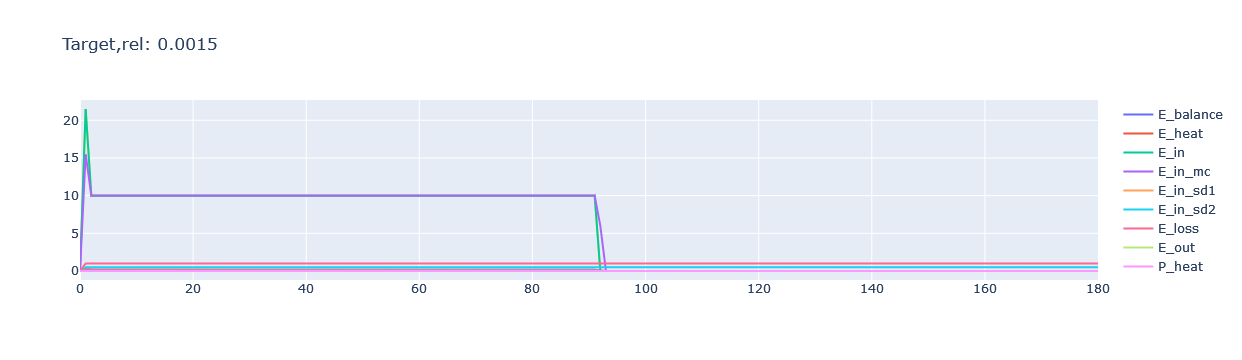

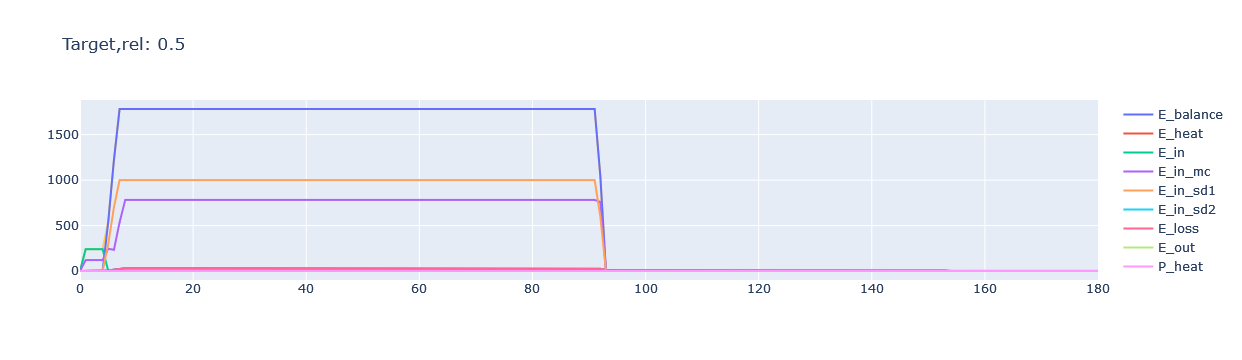

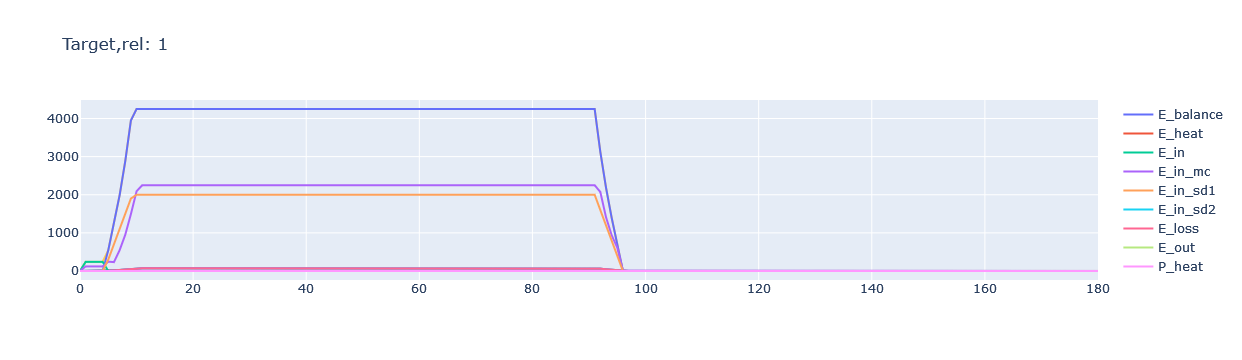

In [32]:
    # Result DataFrame Initialization
    state_attr = [a for a in dir(ECCState()) if not a.startswith('__')]
    df1 = pd.DataFrame(columns=state_attr)
    # Initial state
    df1.loc[0] = vars(ECCState())

    # Run different stationary cases for target output load
    targets = [0,
               0.5 * component.P_out_min_rel / 100,
               component.P_out_min_rel / 100,
               0.5,
               1
               ]

    ts = 1  # min
    n_ts = int(180 / ts)  # number of time steps

    for target in targets:
        C1 = EnergyConversionComponent(par=component,
                                       ts=ts,
                                       state=copy.deepcopy(off_state))
        for t in range(n_ts):
            # print(t)
            if t <= n_ts / 2:
                C1.step_action(target)
            else:
                C1.step_action(0)
            df1.loc[t + 1] = vars(C1.state)

        # Create traces
        fig = go.Figure()
        for cl in df1.columns:
            fig.add_trace(go.Scatter(x=df1.index[:], y=df1[cl][:],
                                     mode='lines',
                                     name=cl))
            fig.update_layout(title=f"Target,rel: {target}")
        fig.show()
